## Panagiotis Doupidis, 89

## Active Learning
---

In [1]:
!pip install modAL --user

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.decomposition import TruncatedSVD
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, DotProduct
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive

import pandas as pd
import numpy as np

np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Load the dataset
X, y = load_diabetes(return_X_y=True)

#### Perform dimensionality reduction using SVD to reduce the number of features to 2 (from 10) in order to display it 

In [4]:
X = TruncatedSVD(n_components=2, n_iter=10, random_state=123).fit_transform(X)

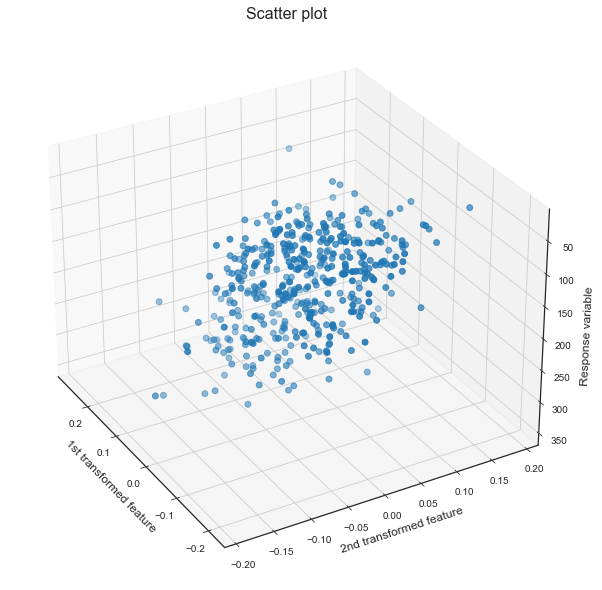

In [5]:
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(10, 15))
    ax = plt.axes(projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, zdir='z', s = 35)
    ax.set_xlabel('1st transformed feature', fontsize=12)
    ax.set_ylabel('2nd transformed feature', fontsize=12)
    ax.set_zlabel('Response variable', fontsize=12)
    ax.view_init(-150, 30)
    plt.title('Scatter plot', fontsize=16)
    plt.show()

#### Because this is a regression and not a classification task we must impose a different uncertainty measure to our active learner. In this case we add the sample that our estimator outputs the highest standart deviation (the most uncertain prediction)

In [6]:
# Defining out query strategy to add new samples
def GP_regression_std(regressor, X):
    preds, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

#### Split dataset to 50% labeled and 50% unlabeled pool

In [7]:
np.random.seed(42)

dataset_size = X.shape[0]

indices_train = np.random.choice(range(len(X)), size=int(dataset_size * .49), replace=False) 

test_temp = np.delete(range(len(X)), indices_train, axis=0)
indices_test = np.random.choice(range(len(X[test_temp])), size=int(len(X[test_temp])/2), replace=False) 

indices_pool = np.delete(range(len(X[test_temp])), indices_test, axis=0)

print(f'Using {indices_train.size} samples for training')
print(f'Using {indices_test.size} samples for testing')
print(f'Using {indices_pool.size} samples in the unlabeled pool')


X_train = X[indices_train]
y_train = y[indices_train]

X_test = X[test_temp][indices_test]
y_test = y[test_temp][indices_test]

X_pool = X[test_temp][indices_pool]
y_pool = y[test_temp][indices_pool]

Using 216 samples for training
Using 113 samples for testing
Using 113 samples in the unlabeled pool


#### Instantiate the model we are going to use - Gaussian Process Regressor

In [8]:
# First initialize the kernel
np.random.seed(42)

kernel_ = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Then the model
gpr = GaussianProcessRegressor(kernel=kernel_)

# Finally the Active Learner
active_learner = ActiveLearner(estimator=gpr, query_strategy=GP_regression_std,
                              X_training=X_train, y_training=y_train)

### Train an initial model before using active learning and observe its performance

In [9]:
y_pred_no_learn, y_std_no_learn = active_learner.predict(X_test, return_std=True)

print('Metrics before Active Learning')
print('=' * 30)
print(f'R2  : {r2_score(y_test, y_pred_no_learn):.5}')
print(f'MSE : {mean_squared_error(y_test, y_pred_no_learn):.5}')
print(f'MAE : {mean_absolute_error(y_test, y_pred_no_learn):.5}')
print(f'ME  : {max_error(y_test, y_pred_no_learn):.5}')
print('=' * 30)

Metrics before Active Learning
R2  : 0.21818
MSE : 4556.4
MAE : 55.726
ME  : 175.61


#### Active Learning approch

##### The number of queries that can be obtained from the oracle can vary although if we assume a resource constrained enviroment this number cannot be arbitralily large without an increase in cost so we choose a reasonably small number of queries in accordance to our dataset size

In [10]:
# First, define the number of queries to include, these can be equal to the unlabeled pool examples
# We can randomly choose some of our pooled instances to be labeled by the Oracle
np.random.seed(42)

queries = 10

print(f'Obtaining the labels for {queries} instances from the Oracle')

for idx in range(queries):
    query_idx, query_instance = active_learner.query(X_pool)
    active_learner.teach(X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,))

Obtaining the labels for 10 instances from the Oracle


In [11]:
y_pred_active, y_std_active = active_learner.predict(X_test, return_std=True)

print('Metrics after Active Learning')
print('=' * 30)
print(f'R2  : {r2_score(y_test, y_pred_active):.5}')
print(f'MSE : {mean_squared_error(y_test, y_pred_active):.5}')
print(f'MAE : {mean_absolute_error(y_test, y_pred_active):.5}')
print(f'ME  : {max_error(y_test, y_pred_active):.5}')

r2 = r2_score(y_test, y_pred_active)
mse = mean_squared_error(y_test, y_pred_active)
mae = mean_absolute_error(y_test, y_pred_active)
me = max_error(y_test, y_pred_active)

print('=' * 30)

Metrics after Active Learning
R2  : 0.23598
MSE : 4452.7
MAE : 55.546
ME  : 175.81


### Random Sampling

#### In this approach, new examples from the pool are not cherry-picked using an active learning querying strategy, rather chosen at random

In [12]:
# First, get random indices from the X_pool, same number as in the active learning model
np.random.seed(2)

random_indices = np.random.choice(range(len(X_pool)), size=queries, replace=False)

# Get a new instance of the Active Learner
active_learner = ActiveLearner(estimator=gpr, query_strategy=GP_regression_std,
                              X_training=X_train, y_training=y_train)

# Now we don't query specific examples based on a strategy, we do it in a random fashion
for idx in random_indices:
    active_learner.teach(X_pool[idx].reshape(1,-1), y_pool[idx].reshape(1,))

In [13]:
y_pred_random, y_std_random = active_learner.predict(X_test, return_std=True)

print('Metrics using Random Sampling')
print('=' * 30)
print(f'R2  : {r2_score(y_test, y_pred_random):.5}')
print(f'MSE : {mean_squared_error(y_test, y_pred_random):.5}')
print(f'MAE : {mean_absolute_error(y_test, y_pred_random):.5}')
print(f'ME  : {max_error(y_test, y_pred_random):.5}')

r2_r = r2_score(y_test, y_pred_random)
mse_r = mean_squared_error(y_test, y_pred_random)
mae_r = mean_absolute_error(y_test, y_pred_random)
me_r = max_error(y_test, y_pred_random)

print('=' * 30)

Metrics using Random Sampling
R2  : 0.21897
MSE : 4551.9
MAE : 55.628
ME  : 176.32


#### Based on the observed regression metrics we can see that the random sampling approach yielded very similar results to our initial experiment (without active learning/random sampling) thus we can conclude that in this particular example and after taking account the specified trained parameters random sampling has not achieved an increase of metrics such as R<sup>2</sup>. Having said that, our main focus here, active learning, has managed to obtain marginally better results accross all metrics. More specifically, we see a noticable jump in R<sup>2</sup> from 0.218 -> 0.236 which should be attributed to the specific examples chosen in order to "enhance" our prediction model as opposed to the random sampling approach which, as mentioned above, didn't manage to surpass the metrics obtained from the original model. 

## Interpretability 
---

In [14]:
# Load the dataset 
df = load_diabetes(as_frame=True)

df.frame.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Split it to train - test (66% - 33%) 

In [15]:
np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, train_size=.66)

In [16]:
def regression_metrics(y_true, y_pred, comment = ''):
    if comment:
        print(comment)
    else:
        pass
    print('=' * 30)
    print(f'R2  : {r2_score(y_true, y_pred):.5}')
    print(f'MSE : {mean_squared_error(y_true, y_pred):.5}')
    print(f'MAE : {mean_absolute_error(y_true, y_pred):.5}')
    print(f'ME  : {max_error(y_true, y_pred):.5}')

#### First train a white-box model (Linear Regression)

In [17]:
lr = LinearRegression()

lr.fit(X_train, y_train)

regression_metrics(y_test, lr.predict(X_test), comment='White-Box predictions')

White-Box predictions
R2  : 0.42803
MSE : 2823.3
MAE : 41.494
ME  : 145.45


#### Train a black box model (Multi Layer Perceptron Regressor)

In [18]:
np.random.seed(0)

mlp = MLPRegressor(hidden_layer_sizes=(128,128,), activation='relu', learning_rate='adaptive', learning_rate_init=3e-2, 
          alpha=1e-6, max_iter=180)

mlp.fit(X_train, y_train)

regression_metrics(y_test, mlp.predict(X_test), comment='Black-Box predictions')

Black-Box predictions
R2  : 0.461
MSE : 2660.5
MAE : 40.117
ME  : 153.53


#### If we base our evaluation on the R<sup>2</sup> metric we realize that the black box approach does indeed yield more accurate predictions
---

#### Global interpretation of White-Box model

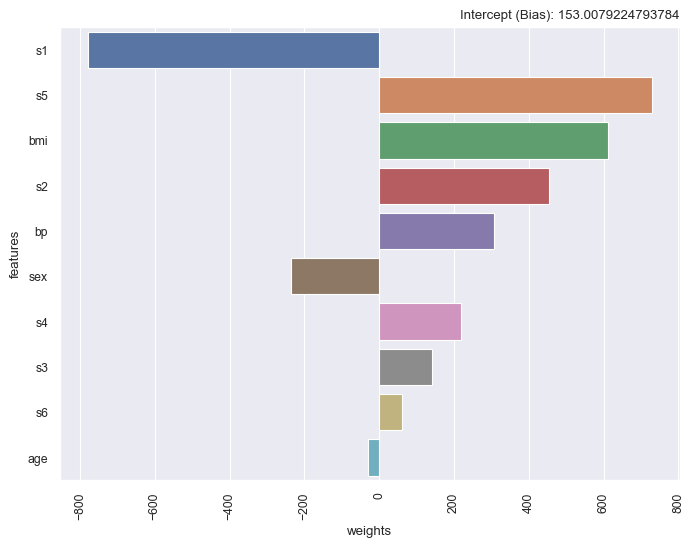

In [19]:
weights = lr.coef_
model_weights = pd.DataFrame({ 'features': list(df.feature_names),'weights': list(weights)})
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index)
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.set_theme(context='paper')
sns.barplot(x="weights", y="features", data=model_weights)
plt.title("Intercept (Bias): "+str(lr.intercept_), loc='right')
plt.xticks(rotation=90)
plt.show()

#### Looking at the plot above we notice that the most important feature in the decision making process of our white-box model is feauture 's1'. Its high negative value suggests that high positive values multiplied by 's1' tend to push the response variable towards lower values.  

#### Local interpretation of white-box model 

Target Value: 78.0
Predicted Value: 119.825
Prediction Error: -41.82503
Sum(weights*instance): -33.1829 + Intercept (Bias): 153.0079 = 119.825


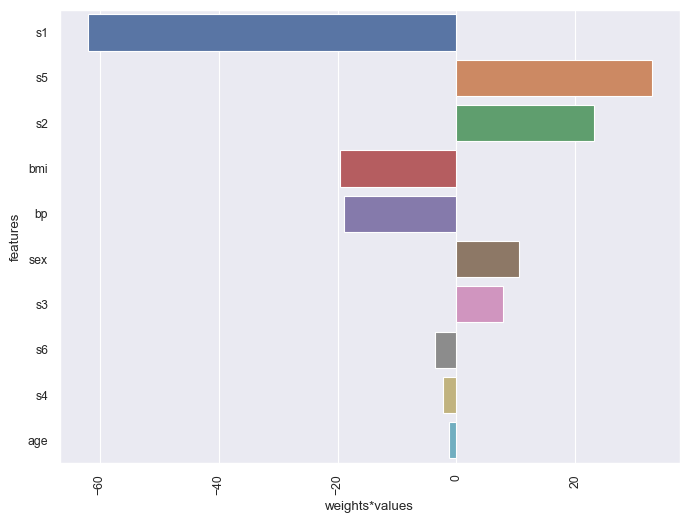

In [20]:
instance = 0

random_instance = X_test.iloc[instance]
print(f"Target Value: {y_test.iloc[instance]:.7}")
print(f"Predicted Value: {lr.predict(X_test)[instance]:.7}")
print(f'Prediction Error: {y_test.iloc[instance] - lr.predict(X_test)[instance]:.7}')
weights = lr.coef_
summation = sum(weights * random_instance)
bias = lr.intercept_
print(f"Sum(weights*instance): {summation:.7} + Intercept (Bias): {bias:.7} = {summation+bias:.7}")

model_weights = pd.DataFrame({ 'features': list(lr.feature_names_in_),'weights*values': list(weights * random_instance)})

model_weights = model_weights.reindex(model_weights['weights*values'].abs().sort_values(ascending=False).index) #Sort by absolute value

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights*values", y="features", data=model_weights)
plt.xticks(rotation=90)
plt.show()

#### Let us consider the first instance of our testing set. Our goal here is to interpret the variables that played the most important role during the decision making process of that particular example. Since we still focus on white-box models which are inherently interpretable, we can claim that the top 3 most important features that influenced the final decision are 's1', 's5' and 's2' (3 features with the highest absolute value of weight scaled by the respective input feature for the test instance). On the other hand, 'age', 's4' and 's6' all have weights*value close to 0 thus they don't play a major part in the value of the response variable for this particular instance. 

### Global interpretation of the Black-Box model (Global Surrogate Model)

#### Train a white-box model on the predictions of the black-box and measure the fidelity

In [21]:
y_train_glob = mlp.predict(X_train)

In [22]:
# Train a Linear Regression model

lr2 = LinearRegression()

lr2.fit(X_train, y_train_glob)

regression_metrics(mlp.predict(X_test), lr2.predict(X_test), comment='Fidelity')

print(f'\nLinear Regression R^2 score on black-boxes predictions: {lr2.score(X_test, y_test):.6}')

Fidelity
R2  : 0.95184
MSE : 123.9
MAE : 8.7644
ME  : 35.206

Linear Regression R^2 score on black-boxes predictions: 0.426462


#### We observe a high fidelity score (focusing on R<sup>2</sup> = 0.95) which means that our surrogate white-box model can successfully imitate the black-box

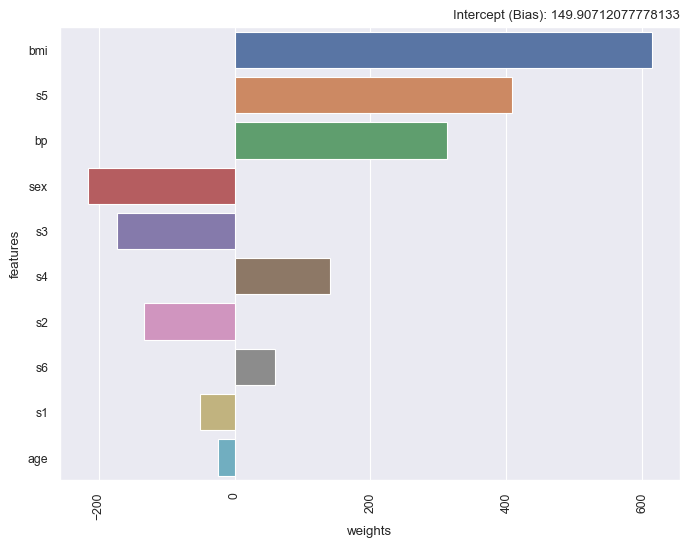

In [23]:
weights = lr2.coef_
model_weights = pd.DataFrame({ 'features': list(df.feature_names),'weights': list(weights)})
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index) 
model_weights = model_weights[(model_weights["weights"] != 0)] 

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.title("Intercept (Bias): "+str(lr2.intercept_),loc='right')
plt.xticks(rotation=90)
plt.show()

#### Using our surrogate white-box model we can now provide some insight into the decision making process of our black-box model since we already established that it can imitate it very accurately. In this global interpretation it seems that 'bmi' is the most important feature followed by 's5'. It is interesting to note that feature 's1' which was the top scoring feature of our original white-box model now ranks at the lower end of the spectrum, making very clear the difference between black and white box models. 

### Local interpretation of a black-box model 

#### First we train a black-box model and compute its predictions on the training set via cross-validation. In this case we select 10-fold CV and a Multi Layer Perceptron model. 

In [24]:
np.random.seed(131)

mlp = MLPRegressor(hidden_layer_sizes=(128,128,), activation='relu', learning_rate='adaptive', learning_rate_init=3e-2, 
          alpha=1e-6, max_iter=600, random_state=131)

mlp.fit(X_train, y_train)

# Compute the predictions of the black-box on the training set using 10-fold cross validation
y_train_glob = cross_val_predict(mlp, X_train, y_train, cv=10, n_jobs=-1,verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished


#### Then, we train a k nearest neighbors regressor on the predictions of the black-box model obtained above 
#### Here we randomly choose k=80

In [25]:
# Fit a KNN model to get the nearest neighbors of an instance
# We also perform a preprocessing step of scaling to ensure that distances are properly calculated
X_train_scaled = StandardScaler().fit_transform(X_train)

knn = KNeighborsRegressor(n_neighbors=80, weights='distance', algorithm='kd_tree', 
                          metric='minkowski', p=2, leaf_size=50)

knn.fit(X_train_scaled, y_train_glob)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=50, n_neighbors=80,
                    weights='distance')

#### Find k nearest neighbors of an instance 

In [26]:
instance_idx = 7
x_instance = X_test.iloc[instance_idx].values.reshape(1, -1)

nn = knn.kneighbors(x_instance, n_neighbors=80, return_distance=False)

#### Train a local white-box model (Linear Regression) using as training set the nearest neighbors of the instance we are interested in

In [27]:
# populate our new x_train, y_train matrices
X_train2 = pd.DataFrame(data=[X_train.iloc[i] for i in nn.flatten()]).reset_index(drop=True)
y_train2 = pd.Series(data=[y_train_glob[i] for i in nn.flatten()], name='y')

print(f'New training set has {len(X_train2.index)} instances')
pd.concat((X_train2, y_train2), axis=1).head()

New training set has 80 instances


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.009016,-0.044642,-0.030996,0.021872,0.008063,0.008707,0.004460,-0.002592,0.009436,0.011349,140.495006
1,0.016281,-0.044642,-0.024529,0.035644,-0.007073,-0.003193,-0.013948,-0.002592,0.015567,0.015491,141.808773
2,0.016281,-0.044642,0.020739,0.021872,-0.013953,-0.013214,-0.006584,-0.002592,0.013316,0.040343,183.275050
3,0.009016,0.050680,0.018584,0.039087,0.017694,0.010586,0.019187,-0.002592,0.016305,-0.017646,148.430114
4,-0.009147,0.050680,-0.030996,-0.026328,-0.011201,-0.001001,-0.021311,-0.002592,0.006209,0.027917,105.569191


#### Train a local linear regression model on the training data above 

In [28]:
lr3 = LinearRegression()

lr3.fit(X_train2, y_train2)

predicted_instance_lr3 = lr3.predict(x_instance)
predicted_instance_mlp = mlp.predict(x_instance)

print(f'Local surrogate LR model predicted {predicted_instance_lr3[0]:.6} for the instance and the black-box predicted {predicted_instance_mlp[0]:.6}')
print(f'Actual value for instance x: {y_test.iloc[instance_idx]}')

Local surrogate LR model predicted 111.922 for the instance and the black-box predicted 115.783
Actual value for instance x: 132.0


Target Value: 132.0
Predicted Value of local linear surrogate model: 111.9221
Predicted Value of Black-Box model: 115.7828
Prediction Error: 20.07795


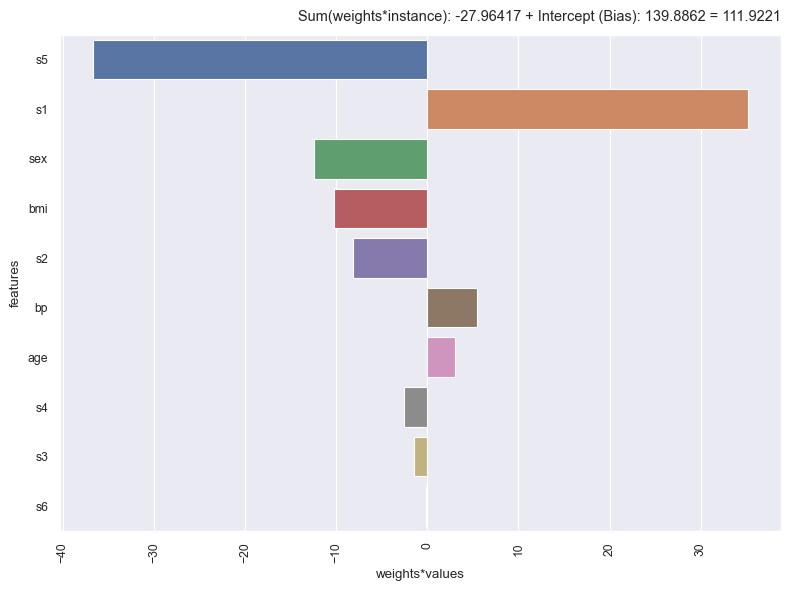

In [29]:
print(f"Target Value: {y_test.iloc[instance_idx]:.7}")
print(f"Predicted Value of local linear surrogate model: {predicted_instance_lr3[0]:.7}")
print(f"Predicted Value of Black-Box model: {predicted_instance_mlp[0]:.7}")
print(f'Prediction Error: {y_test.iloc[instance_idx] - predicted_instance_lr3[0]:.7}')
weights = lr3.coef_
summation = sum(weights * x_instance[0])
bias = lr3.intercept_
#print(f"Sum(weights*instance): {summation:.7} + Intercept (Bias): {bias:.7} = {summation+bias:.7}")

model_weights = pd.DataFrame({ 'features': list(df.feature_names),'weights*values': list(weights * x_instance[0])})
model_weights = model_weights.reindex(model_weights['weights*values'].abs().sort_values(ascending=False).index) #Sort by absolute value
    
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k', tight_layout=1)
plt.title(f"Sum(weights*instance): {summation:.7} + Intercept (Bias): {bias:.7} = {summation+bias:.7}", loc='right', fontsize=10.5, pad=10)
sns.barplot(x="weights*values", y="features", data=model_weights)
plt.xticks(rotation=90)
plt.show()

### After training the local surrogate white-box model we can plot the feature importances as we did before and obtain an explanation as to why the black-box model returned that prediction. We notice that in this instance the local surrogate model and the black-box are not that far apart in terms of the predicted value for this test instance (115.7 vs 111.9). Also, feature 's5' and 's1' seem to be the two most deciding factors in the final value of the response variable having the highest values.